# Problem Statement

The notebook revolves around the task of creating a GAN which takes in a degraded version of an image and generates a clean enhanced image.


#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)
Add any other installation commands you want to in this block.

In [1]:
!pip install GPUtil
!pip install tqdm
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=38325c2be14d45c3c6bc0bdf37285bb5461993cc526fd78b2a0a1a9ac8f5b8a6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


## Downloading and Generating Dataset
This block downloads the data and applies the degrade function on the images to generate the dataset needed for training. The degrade function can be modified and tweaked to better represent the use case in hand.

In [2]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir pubfig831
!mv pubfig83lfw_raw_in_dirs pubfig831/correct
!rm -r pubfig831/correct/distract
!cp -r pubfig831/correct pubfig831/degraded

for image_path in tqdm(glob('pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2020-07-06 07:35:38--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  31.8MB/s    in 9.3s    

2020-07-06 07:35:47 (41.2 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]



100%|██████████| 13002/13002 [01:07<00:00, 192.43it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [1]:
import psutil
import humanize
import os
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 26.4 GB | Proc size 157.8 MB
GPU RAM: Free 16280MB | Used 0MB | Util 0% | Total 16280MB


# **Main Code**

## Data Loading

In [2]:
import os
import numpy as np
import tensorflow as tf
import cv2

RESHAPE = (256,256)

def load_image(path):
    img = cv2.imread(path)
    return img

# converting input to (-1,1)
def preprocess_image(cv_img):
    cv_img = cv2.resize(cv_img,(RESHAPE))
    img = np.array(cv_img)
    img = (img - 127.5) / 127.5
    return img


def deprocess_image(img):
    img = img * 127.5 + 127.5
    return img.astype('uint8')


def load_images(path, n_images):
    if n_images < 0:
        n_images = float("inf")

    all_A_paths = []
    all_B_paths = []
    all_A_paths_test = []
    all_B_paths_test = []

    for root, dire, files in os.walk(path):
      for name in sorted(files):
        filename = os.path.join(root,name)
        if filename.split('/')[-3]=="train":
          if filename.split('/')[-4]=="degraded":
            all_B_paths.append(filename)
          if filename.split('/')[-4]=="correct":
            all_A_paths.append(filename)

        if filename.split('/')[-3]=="test":
          if filename.split('/')[-4]=="degraded":
            all_B_paths_test.append(filename)
          if filename.split('/')[-4]=="correct":
            all_A_paths_test.append(filename)

    images_A, images_B = [], []
    images_A_paths, images_B_paths = [], []
    images_A_test, images_B_test = [], []
    images_A_paths_test, images_B_paths_test = [], []

    for path_A, path_B in zip(all_A_paths, all_B_paths):
        img_A, img_B = load_image(path_A), load_image(path_B)
        images_A.append(preprocess_image(img_A))
        images_B.append(preprocess_image(img_B))
        images_A_paths.append(path_A)
        images_B_paths.append(path_B)
        if len(images_A) > n_images - 1: break

    for path_A_test, path_B_test in zip(all_A_paths_test, all_B_paths_test):
        img_A, img_B = load_image(path_A_test), load_image(path_B_test)
        images_A_test.append(preprocess_image(img_A))
        images_B_test.append(preprocess_image(img_B))
        images_A_paths_test.append(path_A_test)
        images_B_paths_test.append(path_B_test)
        if len(images_A_test) > n_images - 1: break

    return {
        'A': np.array(images_A),
        'A_paths': np.array(images_A_paths),
        'A_test' : np.array(images_A_test),
        'A_paths_test' : np.array(images_A_paths_test),
        'B': np.array(images_B),
        'B_paths': np.array(images_B_paths),
        'B_test' : np.array(images_B_test),
        'B_paths_test' : np.array(images_B_paths_test)
    }


## Structure

### **Constants and Hyperparemeters**

In [3]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization
from keras.layers.merge import Add
from keras.layers.core import Dropout
import tensorflow as tf
import keras
from keras.models import Model
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.layers import Input, Conv2D, Activation, BatchNormalization
from keras.layers.merge import Add
from keras.utils import conv_utils
from keras.layers.core import Dropout
from keras import backend as K


def res_block(input, filters, kernel_size=(3,3), strides=(1,1), use_dropout=False):

    x = ReflectionPadding2D((1,1))(input)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if use_dropout:
        x = Dropout(0.5)(x)

    x = ReflectionPadding2D((1,1))(x)
    x = Conv2D(filters=filters,
                kernel_size=kernel_size,
                strides=strides,)(x)
    x = BatchNormalization()(x)

    # Two convolution layers followed by a direct connection between input and output
    merged = Add()([input, x])
    return merged


# SOURCE for ReflectionPadding2D(Layer): https://github.com/cdiazbas/enhance/blob/master/models.py 
def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):
    """
    Pad the 2nd and 3rd dimensions of a 4D tensor.

    :param x: Input tensor
    :param padding: Shape of padding to use
    :param data_format: Tensorflow vs Theano convention ('channels_last', 'channels_first')
    :return: Tensorflow tensor
    """
    assert len(padding) == 2
    assert len(padding[0]) == 2
    assert len(padding[1]) == 2
    if data_format is None:
        data_format = image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if data_format == 'channels_first':
        pattern = [[0, 0],
                   [0, 0],
                   list(padding[0]),
                   list(padding[1])]
    else:
        pattern = [[0, 0],
                   list(padding[0]), list(padding[1]),
                   [0, 0]]
    return tf.pad(x, pattern, "REFLECT")


class ReflectionPadding2D(Layer):
    """Reflection-padding layer for 2D input (e.g. picture).
    This layer can add rows and columns or zeros
    at the top, bottom, left and right side of an image tensor.
    # Arguments
        padding: int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
            - If int: the same symmetric padding
                is applied to width and height.
            - If tuple of 2 ints:
                interpreted as two different
                symmetric padding values for height and width:
                `(symmetric_height_pad, symmetric_width_pad)`.
            - If tuple of 2 tuples of 2 ints:
                interpreted as
                `((top_pad, bottom_pad), (left_pad, right_pad))`
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    # Input shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, rows, cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, rows, cols)`
    # Output shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, padded_rows, padded_cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, padded_rows, padded_cols)`
    """

    def __init__(self,
                 padding=(1, 1),
                 data_format=None,
                 **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, '__len__'):
            if len(padding) != 2:
                raise ValueError('`padding` should have two elements. '
                                 'Found: ' + str(padding))
            height_padding = conv_utils.normalize_tuple(padding[0], 2,
                                                        '1st entry of padding')
            width_padding = conv_utils.normalize_tuple(padding[1], 2,
                                                       '2nd entry of padding')
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError('`padding` should be either an int, '
                             'a tuple of 2 ints '
                             '(symmetric_height_pad, symmetric_width_pad), '
                             'or a tuple of 2 tuples of 2 ints '
                             '((top_pad, bottom_pad), (left_pad, right_pad)). '
                             'Found: ' + str(padding))
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    input_shape[1],
                    rows,
                    cols)
        elif self.data_format == 'channels_last':
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    rows,
                    cols,
                    input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(inputs,
                                             padding=self.padding,
                                             data_format=self.data_format)

    def get_config(self):
        config = {'padding': self.padding,
                  'data_format': self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Using TensorFlow backend.


### Generator Model

In [4]:
from keras.layers import Input, Activation, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model

image_shape = (256, 256, 3)
ngf = 64
ndf = 64
input_nc = 3
output_nc = 3
input_shape_generator = (256, 256, input_nc)
input_shape_discriminator = (256, 256, output_nc)
n_blocks_gen = 9

def generator_model():
    # Architecture inspired by https://arxiv.org/pdf/1711.07064.pdf
    # Current version : ResNet block
    inputs = Input(shape=image_shape)

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7,7), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Increase filter number, here 2 levels of downsampling
    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # 9 ResNet blocks
    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    # final output after upsampling has 3 channels (RGB) 
    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        x = UpSampling2D(interpolation = 'bilinear')(x)
        x = ReflectionPadding2D((1,1))(x)
        x = Conv2D(filters = int(ngf * mult / 2),kernel_size=(3,3), strides=1, padding='valid')(x)
        # x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = ReflectionPadding2D((3,3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7,7), padding='valid')(x)
    x = Activation('tanh')(x)

    # Add direct connection from input to output and recenter to [-1, 1]
    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Gen')
    return model

### Discriminator Model

In [5]:
from keras.layers import Input, Activation, Add, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Flatten, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model
def discriminator_model():
    
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=ndf*nf_mult, kernel_size=(4, 4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf*nf_mult, kernel_size=(4, 4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4, 4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model

def generator_plus_discriminator(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs])
    return model


### Loss Functions

In [6]:
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
import numpy as np

def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))


def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

### Optimizer

In [7]:

from keras.optimizers import Adam
d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
dg_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

## Preprocessing

In [8]:
# handled in data loading

In [9]:
import warnings
warnings.filterwarnings('ignore')

## Training

In [ ]:
import os
import numpy as np
import tqdm
import logging
from keras.optimizers import Adam

if not os.path.exists('logs'):
    os.makedirs('logs')
logging.basicConfig(filename='logs/train_log.txt', level=logging.INFO)

BASE_DIR = 'weights/'

# saving weights with convention epochnumber in a directory created by datetime
def save_all_weights(d, g, epoch_number, current_loss):
    save_dir = BASE_DIR
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    g.save_weights(os.path.join(save_dir, 'generator_{}.h5'.format(epoch_number)), True)
    d.save_weights(os.path.join(save_dir, 'discriminator_{}.h5'.format(epoch_number)), True)


def train_multiple_outputs(n_images, batch_size, epoch_num, critic_updates=5):
    data = load_images('/content/pubfig831/', n_images)
    y_train, x_train = data['A'], data['B']

    g = generator_model()
    # logging.info("G created")
    d = discriminator_model()
    # logging.info("D Created")
    dg = generator_plus_discriminator(g, d)

    # d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # dg_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    d.trainable = True
    d.compile(optimizer=d_opt, loss=wasserstein_loss)
    # logging.info("D compiled")
    d.trainable = False
    loss = [perceptual_loss, wasserstein_loss]
    loss_weights = [100, 1]
    dg.compile(optimizer=dg_opt, loss=loss, loss_weights=loss_weights)
    # logging.info("DG compiled")
    d.trainable = True

    output_true_batch, output_false_batch = np.ones((batch_size, 1)), -np.ones((batch_size, 1))

    # log_path = './logs'
    # tensorboard_callback = TensorBoard(log_path)

    for epoch in tqdm.tqdm(range(epoch_num)):
        permutated_indexes = np.random.permutation(x_train.shape[0])

        d_losses = []
        dg_losses = []
        # logging.info(f"x_train.shape : {x_train.shape}  y_train.shape : {y_train.shape}")
        for index in range(int(x_train.shape[0] / batch_size)):
            batch_indexes = permutated_indexes[index*batch_size:(index+1)*batch_size]
            image_degraded_batch = x_train[batch_indexes]
            image_full_batch = y_train[batch_indexes]

            generated_images = g.predict(x=image_degraded_batch, batch_size=batch_size)

            for _ in range(critic_updates):
                d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
                d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                d_losses.append(d_loss)

            d.trainable = False

            dg_loss = dg.train_on_batch(image_degraded_batch, [image_full_batch, output_true_batch])
            dg_losses.append(dg_loss)

            d.trainable = True
        logging.info(f"epoch:{epoch} d_loss:{np.mean(d_losses)} dg_loss{np.mean(dg_losses)}")
        print(f"d_losses:{np.mean(d_losses)}, dg_losses:{np.mean(dg_losses)}")
        with open('log.txt', 'a+') as f:
            f.write(f"epoch:{epoch}, d_losses:{np.mean(d_losses)}, dg_losses:{np.mean(dg_losses)}")

        save_all_weights(d, g, epoch, int(np.mean(dg_losses)))



# train_command()
train_multiple_outputs(n_images=1024, batch_size=8, epoch_num=100, critic_updates=5)


58892288/58889256 [==============================] - 1s 0us/step


  0%|          | 0/100 [00:00<?, ?it/s]

d_losses:-0.46315189328379347, dg_losses:0.1268453598022461


  1%|          | 1/100 [02:31<4:09:34, 151.26s/it]

d_losses:-0.4982677516527474, dg_losses:0.0028363680467009544


  2%|▏         | 2/100 [04:33<3:52:51, 142.57s/it]

d_losses:-0.46702319885184507, dg_losses:0.2540637254714966


  3%|▎         | 3/100 [06:36<3:40:52, 136.63s/it]

d_losses:-0.4484803271770943, dg_losses:0.1926455944776535


  4%|▍         | 4/100 [08:39<3:32:18, 132.69s/it]

d_losses:-0.45126046659810815, dg_losses:0.20212148129940033


  5%|▌         | 5/100 [10:42<3:25:08, 129.57s/it]

d_losses:-0.15055622796523677, dg_losses:0.24603156745433807


  6%|▌         | 6/100 [12:45<3:20:18, 127.85s/it]

## Evaluation

In [ ]:
Prediction and test code with some visualizations [ground truth, degraded, fixed]
from matplotlib.pyplot import plot, imshow
import matplotlib.pyplot as plt
import random
%matplotlib inline

def test(batch_size):
    data = load_images('/content/pubfig831/', batch_size)
    y_test, x_test = data['A_test'], data['B_test']
    g = generator_model()
    g.load_weights('/content/weights/generator_19.h5')
    # x_test = np.random.shuffle(x_test)
    generated_images = g.predict(x=x_test, batch_size=batch_size)
    generated = np.array([deprocess_image(img) for img in generated_images])
    x_test = deprocess_image(x_test)
    y_test = deprocess_image(y_test)
    fig, axes = plt.subplots(5, 1, figsize=(16, 16), sharex=True, sharey=True)
    ax = axes.ravel()

    # show output
    for i in range(generated_images.shape[0]):
        y = y_test[i, :, :, ::-1]
        x = x_test[i, :, :, ::-1]
        img = generated[i, :, :, ::-1]
        output = np.concatenate((y, x, img), axis=1)
        im = Image.fromarray(output.astype(np.uint8))
        im.save('results{}.png'.format(i))
        ax[i].imshow(im)
    fig.tight_layout()
    plt.show()



test(5)

In [ ]:
# Prediction for just 1 image and saving output as solo.png again using skimage formats
def test_img(test_path):
  g = generator_model()
  g.load_weights('/content/weights/generator_19.h5')
  img_test = load_image(test_path)
  img_test = preprocess_image(img_test)
  print(img_test.shape)
  img_test = np.expand_dims(img_test, 0)
  print(img_test.shape)
  gen = g.predict(x=img_test, batch_size=1)

  gen = np.array(deprocess_image(gen[0]))
  print(gen.shape)
  im = Image.fromarray(gen)
  im.save('solo.png')


test_img('/content/pubfig831/degraded/test/Adam Sandler/test__000001-000004.jpg')


In [ ]:

def fix(image: np.ndarray) -> np.ndarray:
    """
    This function should take a degraded image in BGR format as a 250x250x3
    numpy array with dtype np.uint8, and return its fixed version in the same format.

    Make sure you don't return floating point values, or RGB instead of BGR, else the
    image will look completely wrong when displayed.
    """
    g = generator_model()
    g.load_weights('/content/generator_60.h5')
    img_test = preprocess_image(image)
    img_test = np.expand_dims(img_test, 0)
    gen = g.predict(img_test)
    gen = np.array(deprocess_image(gen[0]))
    gen = cv2.resize(gen,(250,250))
    return gen



# Results


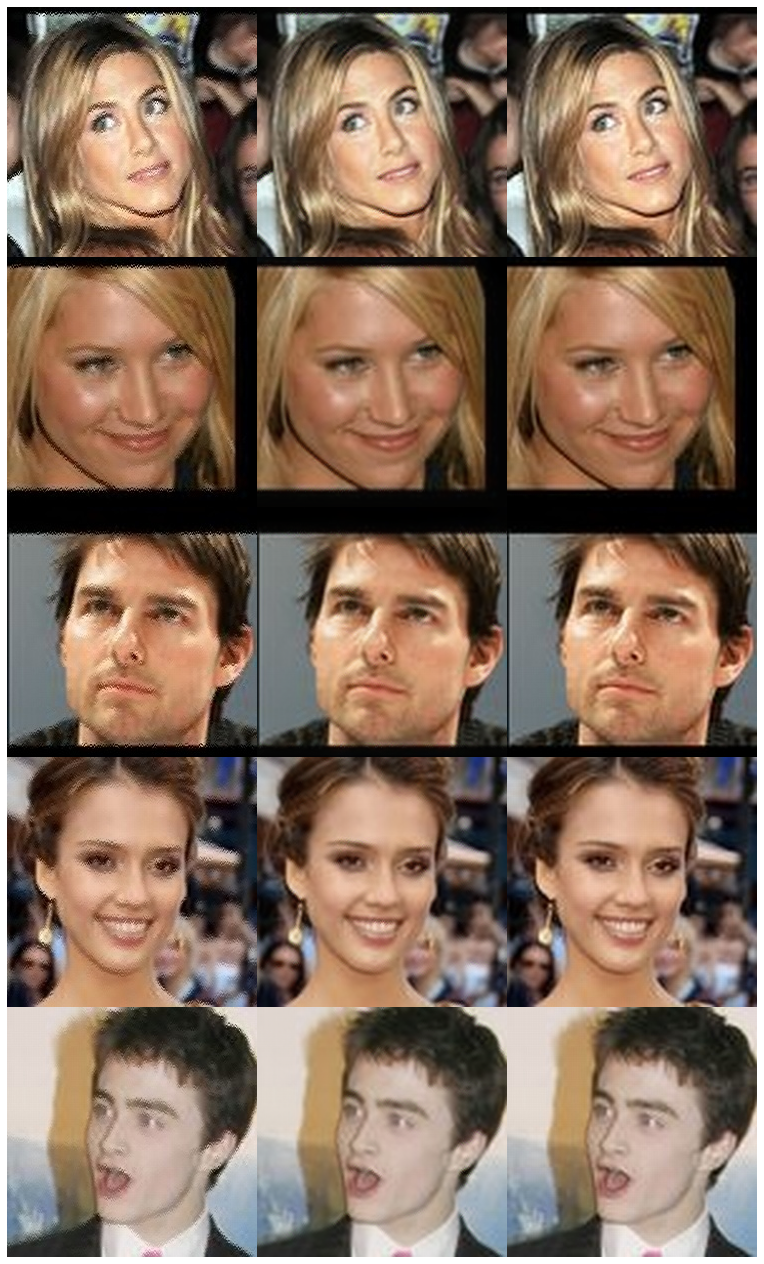

In [ ]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/pubfig831/correct/test/*/*')
grid = []

for path in random.sample(files, NUM_DISPLAY):
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  fixed = fix(degraded)
  grid.append(np.column_stack([degraded, fixed, correct]))

image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()